# Recurrent Neural Networks - Part 2

In part 1, we implemented a recurrent neural network and did some preliminary optimization. We will now do a more systematic approach of all variants of data preparation, and network architecture. We will look to maximize the decoding accuracy on the test set, which will consist of entire sessions, and test error randomness with KS and Kuiper's tests. The following variables will be tested:  

1) sequences of length drawn from N(mu,sigma) or each sequence is a block
2) sequences are one-hot encoded vectors, or we are mixing inputs (more explanation needed here)
3) dimension of hidden units, e.g. 20, 100, 200 hidden units
4) # of epochs, how long we want network to train for  

Again, there are 4 datasets, with sequences split as in (1), and with reward/choice inputs being combined or not as in (2). 

In [2]:
ROOT = '/Users/pablomartin/python/'
#standard modules
import sys
if ROOT not in sys.path:
    sys.path.append(ROOT)

import pandas as pd
import numpy as np
from scipy.stats import uniform
import os
import pickle
import time
import matplotlib.pyplot as plt
import itertools
import multiprocessing as mp
#my modules
from behavioral_performance.utils import *
from behavioral_performance.kuiper import kuiper
from RNNmodule.utils import *
from RNNmodule.RNNclass import RNN
from RNNmodule.create_sequences import *
from RNNmodule.model_evaluation import *
from Visualize.decoding import *

print 'done loading modules...'

RANDOM_STATE = 11
data_dir = ROOT + 'DATA_structures/TbyT/'
sequence_dir = ROOT + 'DATA_structures/RNN_sequences'
model_dir = ROOT + 'Models/RNN'
data_type = ['combined_input', 'not_combined']
sequence_split = ['random_lengths', 'by_block']
hidden_dimensions = [5, 10, 15, 20, 50, 100, 150]

        

done loading modules...


## Creating Sequences
We will take every dataset and split it into chunks of sequences as explained above. We will create an object callede sequences that will store the training and testing sets and the RANDOM_STATE which was the seed as to how to split them. There will be 4 "types" of sequences. We will keep all sequences as pandas Series because of ease of splitting and joining without losing the identity of the sequence. We will save all the sequences into target folders. 


In [2]:
for fileName, dt, ss in itertools.product(fileNames, data_type, sequence_split):
    print 'processing dataset %s - %s - %s' %(fileName, dt, ss)
    
    #loading data
    df = pickle.load(open(data_dir + fileName, 'rb'))

    
    #split into train and test split
    train_slice, test_slice = my_train_test_split(df, RANDOM_STATE = RANDOM_STATE)
    
    #transform data to right format
    if dt == 'combined_input':
        data = choice_reward_combined(df)
        split_xy = sequence_to_xy_combined
    elif dt == 'not_combined':
        data = choice_reward_not_combined(df)
        split_xy = sequence_to_xy_not_combined


    #actually split data into train and test sets
    if len(data.shape) == 1:
        train = data.loc[train_slice]
        test = data.loc[test_slice]             
    elif len(data.shape) == 2:
        train = data.loc[train_slice, :]
        test = data.loc[test_slice, :] 

    #create object
    sequence_set = Sequences(dt, ss, RANDOM_STATE = RANDOM_STATE)

    if ss == 'random_lengths':
        split_function = random_split_session
    elif ss == 'by_block':
        split_function = block_split_session

    train_sequences = []
    test_sequences = []
    for label, session in train.groupby(axis = 0, level = 'session'):
        train_sequences += split_function(session)
    for label, session in test.groupby(axis = 0, level = 'session'):
        test_sequences += split_function(session)

    X_train = []
    y_train = []
    X_test = []
    y_test = []
    for setIndex, Set in enumerate([train_sequences, test_sequences]):
        for seq in Set:
            X, y = split_xy(seq)
            if setIndex == 0:
                X_train.append(X)
                y_train.append(y)
            else: 
                X_test.append(X)
                y_test.append(y)

    sequence_set.X_train = X_train
    sequence_set.y_train = y_train
    sequence_set.X_test = X_test
    sequence_set.y_test = y_test
    path = '/'.join([sequence_dir, dt, ss, fileName])
    pickle.dump(sequence_set, open(path, 'wb'))
    print 'created sequence object %s - %s' %(dt, ss)
            
print 'DONE.'

                

processing dataset DSR_TbyT_FirstTraining.p - combined_input - random_lengths
created sequence object combined_input - random_lengths
processing dataset DSR_TbyT_FirstTraining.p - combined_input - by_block
created sequence object combined_input - by_block
processing dataset DSR_TbyT_FirstTraining.p - not_combined - random_lengths
created sequence object not_combined - random_lengths
processing dataset DSR_TbyT_FirstTraining.p - not_combined - by_block
created sequence object not_combined - by_block
processing dataset PSR_TbyT_FirstTraining.p - combined_input - random_lengths
created sequence object combined_input - random_lengths
processing dataset PSR_TbyT_FirstTraining.p - combined_input - by_block
created sequence object combined_input - by_block
processing dataset PSR_TbyT_FirstTraining.p - not_combined - random_lengths
created sequence object not_combined - random_lengths
processing dataset PSR_TbyT_FirstTraining.p - not_combined - by_block
created sequence object not_combined - b

## Entropy Checks
We created a lot of data, with slightly different format to the template RNN that we were using. Entropy checks will help us test the forward propagation function with the more generalized input types

In [2]:
for fileName, dt, ss in itertools.product(fileNames, data_type, sequence_split):

    path = '/'.join([sequence_dir, dt, ss, fileName])
    seqObject = pickle.load(open(path, 'rb'))
    print path
    myRNN = RNN(noFeatures = 4, hidden_dim = 10,
                bptt_truncate = 4, RANDOM_STATE = seqObject.RANDOM_STATE)

    entropy = myRNN.calculate_loss([seq.values for seq in seqObject.X_train],
                                   [seq.values for seq in seqObject.y_train])   
    print 'Expected entropy: %1.4f\nActual entropy: %1.4f' %(np.log(4), entropy)     
        

/Users/pablomartin/python/DATA_structures/RNN_sequences/combined_input/random_lengths/DSR_TbyT_FirstTraining.p
Expected entropy: 1.3863
Actual entropy: 1.3595
/Users/pablomartin/python/DATA_structures/RNN_sequences/combined_input/by_block/DSR_TbyT_FirstTraining.p
Expected entropy: 1.3863
Actual entropy: 1.3690
/Users/pablomartin/python/DATA_structures/RNN_sequences/not_combined/random_lengths/DSR_TbyT_FirstTraining.p
Expected entropy: 1.3863
Actual entropy: 1.3462
/Users/pablomartin/python/DATA_structures/RNN_sequences/not_combined/by_block/DSR_TbyT_FirstTraining.p
Expected entropy: 1.3863
Actual entropy: 1.4466
/Users/pablomartin/python/DATA_structures/RNN_sequences/combined_input/random_lengths/PSR_TbyT_FirstTraining.p
Expected entropy: 1.3863
Actual entropy: 1.5219
/Users/pablomartin/python/DATA_structures/RNN_sequences/combined_input/by_block/PSR_TbyT_FirstTraining.p
Expected entropy: 1.3863
Actual entropy: 1.4654
/Users/pablomartin/python/DATA_structures/RNN_sequences/not_combined

## Gradient Checks
It is imperative that we do gradient checks for one example of each type of dataset. This will mainly test the back propagation thru time function, which is the meat and potatoes of the whole thing. It may take a while but it is a very important step, before we can move on and train all the networks.  

EDIT: actually, if we make the hidden_dim small, these are very fast. I think that it does not matter for checking gradients what the size of this matrix is. 

In [7]:
            
#since gradient checks are much more expensive, we will only check for each input type
fileName = fileNames[0]
for dt in data_type:
    for ss in sequence_split:
        path = '/'.join([sequence_dir, dt, ss, fileName])
        seqObject = pickle.load(open(path, 'rb'))
        myRNN = RNN(noFeatures = 4, hidden_dim = 20,
            bptt_truncate = 4, RANDOM_STATE = seqObject.RANDOM_STATE)
        myRNN.gradient_check(seqObject.X_train[0].values, seqObject.y_train[0].values)

Performing gradient check for parameter Wxh with size 80.
Gradient check for parameter Wxh passed.
Performing gradient check for parameter Whh with size 400.
Gradient check for parameter Whh passed.
Performing gradient check for parameter Why with size 80.
Gradient check for parameter Why passed.
Performing gradient check for parameter Wxh with size 80.
Gradient check for parameter Wxh passed.
Performing gradient check for parameter Whh with size 400.
Gradient check for parameter Whh passed.
Performing gradient check for parameter Why with size 80.
Gradient check for parameter Why passed.
Performing gradient check for parameter Wxh with size 80.
Gradient check for parameter Wxh passed.
Performing gradient check for parameter Whh with size 400.
Gradient check for parameter Whh passed.
Performing gradient check for parameter Why with size 80.
Gradient check for parameter Why passed.
Performing gradient check for parameter Wxh with size 80.
Gradient check for parameter Wxh passed.
Perform

## Train Network - Parallel Computing

Since gradient and entropy checks cleared for all datasets, we can move on to training the network. Here we can vary the 2 following parameters:  

1) the dimension of the hidden units
2) the # of epochs to train the network  

First, we define a function that given the right path to the sequences, will save a trained network to the directory specified in model_path. We will need to do everything in parallel here because this step can take forever. We will test on local computer and afterwards send to epsilon and use those 32 cores.

In [5]:
def train_network(sequence_path, model_path, hidden_dim = 20, nepoch = 100):
    print 'training network: %s' %sequence_path
    if not os.path.isfile(sequence_path):
        print 'WARNING: could not find sequences'
    if not os.path.isdir(model_path):
        print 'WARNING: model path file is invalid'
        
    seqObject = pickle.load(open(sequence_path, 'rb'))
    #instantiate RNN for that set of sequences
    myRNN = RNN(noFeatures = 4,
                hidden_dim = hidden_dim,
                bptt_truncate = 30,
                RANDOM_STATE = seqObject.RANDOM_STATE)
    #train the network
    myRNN.train_with_sgd([seq.values for seq in seqObject.X_train],
                         [seq.values for seq in seqObject.y_train],
                         learning_rate = 0.005,
                         nepoch = nepoch)
    #save the network
    pickle.dump(myRNN, open(model_path, 'wb'))


#we have 32 cores !
pool = mp.Pool(processes=32)

for fileName, dt, ss, hd in \
    itertools.product(fileNames, data_type, sequence_split, hidden_dimensions):
    #load appropriate sequences
    sequence_path = '/'.join([sequence_dir, dt, 'random_lengths', ss, fileName])
    model_path = '/'.join([model_dir, dt, 'random_lenghts', ss,
                        fileName[:fileName.find('.')] + str(hd) + '.p'])
    pool.apply_async(train_network, [sequence_path, model_path, hd, 300])

training network: /Users/pablomartin/python/DATA_structures/RNN_sequences/combined_input/random_lengths/DSR_TbyT_FirstTraining.p
training network: /Users/pablomartin/python/DATA_structures/RNN_sequences/combined_input/random_lengths/DSR_TbyT_FirstTraining.p
training network: /Users/pablomartin/python/DATA_structures/RNN_sequences/combined_input/random_lengths/DSR_TbyT_FirstTraining.p
training network: /Users/pablomartin/python/DATA_structures/RNN_sequences/combined_input/random_lengths/DSR_TbyT_FirstTraining.p
2018-07-05 00:45:24: Loss after num_examples_seen=0 epoch=0: 1.489844
2018-07-05 00:45:24: Loss after num_examples_seen=0 epoch=0: 1.302865
2018-07-05 00:45:24: Loss after num_examples_seen=0 epoch=0: 1.215079
2018-07-05 00:45:24: Loss after num_examples_seen=0 epoch=0: 1.541379
2018-07-05 00:45:26: Loss after num_examples_seen=150 epoch=5: 0.703389
2018-07-05 00:45:26: Loss after num_examples_seen=150 epoch=5: 0.706153
2018-07-05 00:45:26: Loss after num_examples_seen=150 epoch=

2018-07-05 00:46:00: Loss after num_examples_seen=3750 epoch=125: 0.586067
2018-07-05 00:46:00: Loss after num_examples_seen=3600 epoch=120: 0.457304
2018-07-05 00:46:00: Loss after num_examples_seen=3750 epoch=125: 0.554691
2018-07-05 00:46:01: Loss after num_examples_seen=3750 epoch=125: 0.539448
2018-07-05 00:46:01: Loss after num_examples_seen=3900 epoch=130: 0.585885
2018-07-05 00:46:01: Loss after num_examples_seen=3750 epoch=125: 0.451455
2018-07-05 00:46:01: Loss after num_examples_seen=3900 epoch=130: 0.554376
2018-07-05 00:46:02: Loss after num_examples_seen=3900 epoch=130: 0.536632
2018-07-05 00:46:02: Loss after num_examples_seen=4050 epoch=135: 0.585708
2018-07-05 00:46:03: Loss after num_examples_seen=3900 epoch=130: 0.445494
2018-07-05 00:46:03: Loss after num_examples_seen=4050 epoch=135: 0.554072
2018-07-05 00:46:04: Loss after num_examples_seen=4050 epoch=135: 0.534267
2018-07-05 00:46:04: Loss after num_examples_seen=4200 epoch=140: 0.585535
2018-07-05 00:46:04: Loss

2018-07-05 00:46:39: Loss after num_examples_seen=7800 epoch=260: 0.550929
2018-07-05 00:46:39: Loss after num_examples_seen=7650 epoch=255: 0.468845
2018-07-05 00:46:40: Loss after num_examples_seen=7950 epoch=265: 0.583286
Setting learning rate to 0.000156
2018-07-05 00:46:40: Loss after num_examples_seen=7650 epoch=255: 0.361761
2018-07-05 00:46:40: Loss after num_examples_seen=7950 epoch=265: 0.550853
2018-07-05 00:46:41: Loss after num_examples_seen=7800 epoch=260: 0.465078
2018-07-05 00:46:41: Loss after num_examples_seen=8100 epoch=270: 0.573397
2018-07-05 00:46:41: Loss after num_examples_seen=7800 epoch=260: 0.361398
2018-07-05 00:46:42: Loss after num_examples_seen=8100 epoch=270: 0.550778
2018-07-05 00:46:42: Loss after num_examples_seen=7950 epoch=265: 0.459466
2018-07-05 00:46:43: Loss after num_examples_seen=8250 epoch=275: 0.573265
2018-07-05 00:46:43: Loss after num_examples_seen=7950 epoch=265: 0.361001
2018-07-05 00:46:43: Loss after num_examples_seen=8250 epoch=275: 

2018-07-05 00:47:23: Loss after num_examples_seen=2990 epoch=130: 0.605251
2018-07-05 00:47:23: Loss after num_examples_seen=1950 epoch=65: 0.246536
Setting learning rate to 0.001250
2018-07-05 00:47:24: Loss after num_examples_seen=3105 epoch=135: 0.605218
2018-07-05 00:47:24: Loss after num_examples_seen=1350 epoch=45: 0.345275
2018-07-05 00:47:25: Loss after num_examples_seen=2700 epoch=90: 0.351211
Setting learning rate to 0.001250
2018-07-05 00:47:25: Loss after num_examples_seen=3220 epoch=140: 0.605191
2018-07-05 00:47:25: Loss after num_examples_seen=2100 epoch=70: 0.158275
2018-07-05 00:47:26: Loss after num_examples_seen=3335 epoch=145: 0.605171
2018-07-05 00:47:26: Loss after num_examples_seen=2850 epoch=95: 0.262267
2018-07-05 00:47:27: Loss after num_examples_seen=3450 epoch=150: 0.605159
2018-07-05 00:47:27: Loss after num_examples_seen=1500 epoch=50: 0.306269
2018-07-05 00:47:28: Loss after num_examples_seen=2250 epoch=75: 0.140369
2018-07-05 00:47:28: Loss after num_exa

Setting learning rate to 0.000625
2018-07-05 00:48:11: Loss after num_examples_seen=3450 epoch=115: 0.081298
2018-07-05 00:48:11: Loss after num_examples_seen=4950 epoch=165: 0.082228
2018-07-05 00:48:11: Loss after num_examples_seen=6450 epoch=215: 0.109158
2018-07-05 00:48:12: Loss after num_examples_seen=1380 epoch=60: 0.595671
2018-07-05 00:48:13: Loss after num_examples_seen=6600 epoch=220: 0.107936
2018-07-05 00:48:13: Loss after num_examples_seen=1495 epoch=65: 0.595023
2018-07-05 00:48:13: Loss after num_examples_seen=5100 epoch=170: 0.081674
2018-07-05 00:48:14: Loss after num_examples_seen=1610 epoch=70: 0.594464
2018-07-05 00:48:14: Loss after num_examples_seen=3600 epoch=120: 0.080592
2018-07-05 00:48:15: Loss after num_examples_seen=6750 epoch=225: 0.106749
2018-07-05 00:48:15: Loss after num_examples_seen=1725 epoch=75: 0.593924
2018-07-05 00:48:15: Loss after num_examples_seen=5250 epoch=175: 0.081170
2018-07-05 00:48:16: Loss after num_examples_seen=1840 epoch=80: 0.593

Process PoolWorker-29:
Process PoolWorker-32:
Process PoolWorker-30:
Process PoolWorker-31:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Applications/anaconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/Applications/anaconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/Applications/anaconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
Traceback (most recent call last):
    self.run()
    self.run()
    self.run()
  File "/Applications/anaconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/Applications/anaconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/Applications/anaconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/Applications/anaconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
    s

## Optimizing Network Width
Above code got sent to epsilon and we took advantage of the 32 cores. We transfer back all the trained models and now we think about how to compare them. Models will not be compared accross ways of splitting the data. Within a type of input sequence, we will maximize over performance on the testing set. That will determine the size of the hidden dimensions, which may vary accross datasets. Once those are picked for each dataset, we will make a model grid for each input sequence type.


In [8]:
cols = pd.MultiIndex.from_product([data_type,sequence_split],
                                  names = ['data_type', 'seq_split'])
hidden_dimension_optimized = pd.DataFrame(np.zeros([len(fileNames), len(cols)], dtype=int),
                                          index = fileNames,
                                          columns = cols)

for dt, ss, fileName in itertools.product(data_type, sequence_split, fileNames):
    if dt == 'combined_input':
        test_func = test_model_on_test_set_combined
    elif dt == 'not_combined':
        test_func = test_model_on_test_not_combined
        
    #load appropriate sequences 
    sequence_path = '/'.join([sequence_dir, dt, ss, fileName])
    seqObject = pickle.load(open(sequence_path, 'rb'))
    
    #getting all models that were trained for that dataset
    model_path = '/'.join([model_dir, dt, ss])
    trained_models = [trained_model for trained_model in os.listdir(model_path) \
                      if trained_model.startswith(fileName[:-2])]
    model_scores = dict()
    #we iterate thru all trained models
    for hd_index, trained_model in enumerate(trained_models):
        #load model
        model_path = '/'.join([model_dir, dt, ss, trained_model])
        model = pickle.load(open(model_path, 'rb'))
        
        #check that data was split the same way 
        if seqObject.RANDOM_STATE != model.random_state:
            print 'ERROR - %s - %s' %(sequence_path, model_path)
            
        #go thru each sequence and test prediction accuracy    
        hits, noTrials = 0, 0
        for x, y in zip(seqObject.X_test, seqObject.y_test):
            h, nT, preds = test_func(model, x.values, y.values)
            hits += h
            noTrials += nT
        model_scores[trained_model] = np.float(hits) / noTrials
        
    winner = max(model_scores, key=model_scores.get)
    HD_optimal = int(winner[len(fileName[:-2]):-2])

    hidden_dimension_optimized.loc[fileName, idx[dt, ss]] = HD_optimal
    print 'for %s - %s - %s .... optimal dimension is %i - score: %1.4f' \
    %(fileName, dt, ss, HD_optimal,  np.max(model_scores.values()))

pickle.dump(hidden_dimension_optimized,
            open(ROOT + 'Model_Evaluation/RNN/hidden_dimension_optimization.p', 'wb'))
print 'DONE.'

for DSR_TbyT_FirstTraining.p - combined_input - random_lengths .... optimal dimension is 8 - score: 0.6835
for PSR_TbyT_FirstTraining.p - combined_input - random_lengths .... optimal dimension is 10 - score: 0.7500
for DSR_TbyT_MidTraining.p - combined_input - random_lengths .... optimal dimension is 3 - score: 0.7041
for PSR_TbyT_MidTraining.p - combined_input - random_lengths .... optimal dimension is 15 - score: 0.6459
for DSR_TbyT_Saline.p - combined_input - random_lengths .... optimal dimension is 3 - score: 0.7346
for PSR_TbyT_Saline.p - combined_input - random_lengths .... optimal dimension is 8 - score: 0.6891
for DSR_TbyT_MPFC.p - combined_input - random_lengths .... optimal dimension is 3 - score: 0.7302
for PSR_TbyT_MPFC.p - combined_input - random_lengths .... optimal dimension is 5 - score: 0.7724
for DSR_TbyT_OFC.p - combined_input - random_lengths .... optimal dimension is 10 - score: 0.7470
for PSR_TbyT_OFC.p - combined_input - random_lengths .... optimal dimension is 6

## Feedforward Datasets

Now we push all the datasets thru the optimized networks and observe the outputs as per the model grid plot. We will get 4 of these, one for each type of input sequence.

In [9]:
HDO = pickle.load(open(ROOT + 'Model_Evaluation/RNN/hidden_dimension_optimization.p', 'rb'))
for dt, ss in itertools.product(data_type, sequence_split):
    if dt == 'combined_input':
        test_func = test_model_on_test_set_combined
    elif dt == 'not_combined':
        test_func = test_model_on_test_not_combined
    scores = create_model_grid()
    for fileName in fileNames:
        model_task, model_regime = filename_to_label(fileName)
        print 'working on %s - %s - %s - %s' %(dt, ss, model_task, model_regime)
        #loading the highest scoring model
        hd = HDO.loc[fileName, idx[dt,ss]]
        model_path = '/'.join([model_dir, dt, ss, fileName[:fileName.find('.')] + str(hd) + '.p'])
        print model_path
        model = pickle.load(open(model_path, 'rb'))
        #now we iterate thru the datasets
        for compFileName in fileNames:
            data_task, data_regime = filename_to_label(compFileName)
            #load appropriate sequences 
            sequence_path = '/'.join([sequence_dir, dt, ss, compFileName])
            seqObject = pickle.load(open(sequence_path, 'rb'))
            #run model on test set
            if fileName == compFileName:
                X = seqObject.X_test
                y = seqObject.y_test
            #if not same dataset, we can use entire data to test model
            else:
                X = seqObject.X_test + seqObject.X_train
                y = seqObject.y_test + seqObject.y_train
            hits = 0
            totalTrials = 0
            for X_seq, y_seq in zip(X, y):
                h, nT, preds = test_func(model, X_seq.values, y_seq.values)
                hits += h
                totalTrials += nT      
            scores.loc[idx[model_task, model_regime], 
                       idx[data_task, data_regime ]] = np.float(hits) / totalTrials
            
    pickle.dump(scores,
                open(ROOT + 'Model_Evaluation/RNN/model_grid' + '_'.join(['',dt,ss,'.p']), 'wb'))
    print '{:*^30}'.format('done with sequence type')

working on combined_input - random_lengths - DSR - FirstTraining
/Users/pablomartin/python/Models/RNN/combined_input/random_lengths/DSR_TbyT_FirstTraining8.p
working on combined_input - random_lengths - PSR - FirstTraining
/Users/pablomartin/python/Models/RNN/combined_input/random_lengths/PSR_TbyT_FirstTraining10.p
working on combined_input - random_lengths - DSR - MidTraining
/Users/pablomartin/python/Models/RNN/combined_input/random_lengths/DSR_TbyT_MidTraining3.p
working on combined_input - random_lengths - PSR - MidTraining
/Users/pablomartin/python/Models/RNN/combined_input/random_lengths/PSR_TbyT_MidTraining15.p
working on combined_input - random_lengths - DSR - Saline
/Users/pablomartin/python/Models/RNN/combined_input/random_lengths/DSR_TbyT_Saline3.p
working on combined_input - random_lengths - PSR - Saline
/Users/pablomartin/python/Models/RNN/combined_input/random_lengths/PSR_TbyT_Saline8.p
working on combined_input - random_lengths - DSR - MPFC
/Users/pablomartin/python/Mode

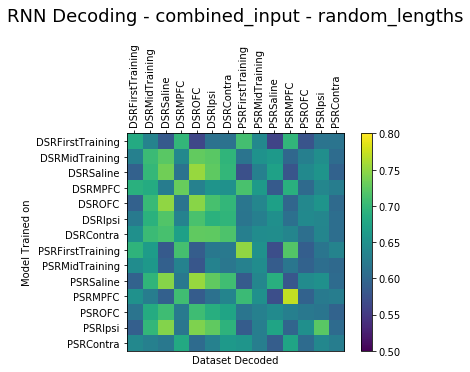

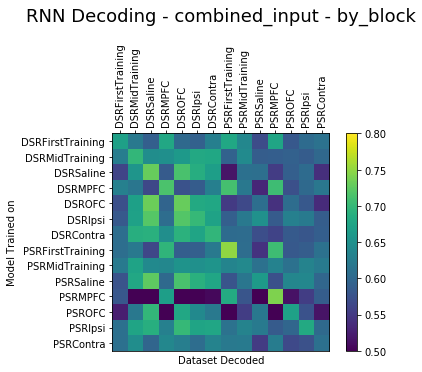

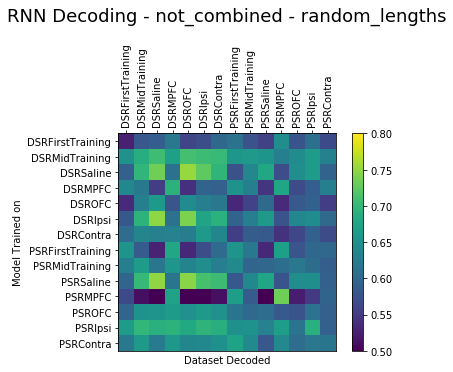

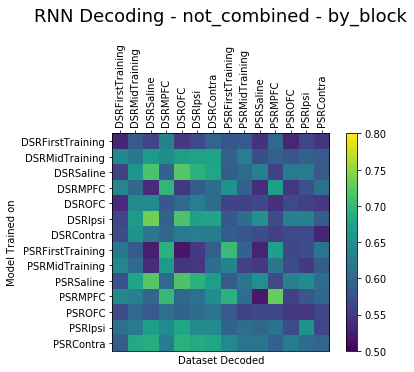

In [10]:
for dt, ss in itertools.product(data_type, sequence_split):
    scores = pickle.load(open(ROOT + 'Model_Evaluation/RNN/model_grid' + '_'.join(['',dt,ss,'.p']), 'rb'))
    plot_model_grid(scores, [0.5, 0.8], title = 'RNN Decoding - %s - %s' %(dt, ss))

## Visualize Test Sessions
We want to get a sense of how an RNN is producing output. We saw in the logistic regression, the model implements something 'like' a square wave, it banks left or right given the recent past. Are RNN truly catching another pattern ? We will plot the output of the model on the test sessions, against the true behavior, and then do some stats.

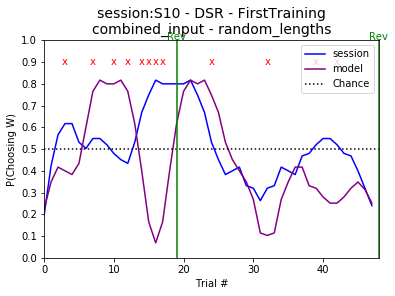

*****KS PASSED - p: 0.15******
***Kuiper PASSED - p: 0.19****


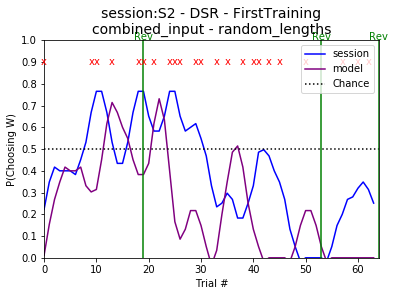

*****KS PASSED - p: 0.88******
***Kuiper PASSED - p: 0.98****


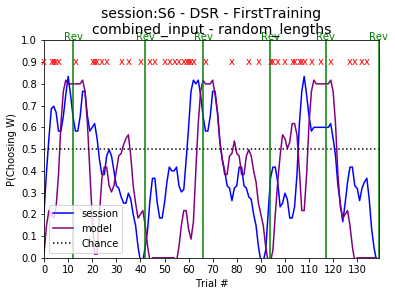

*****KS PASSED - p: 0.63******
***Kuiper PASSED - p: 1.00****


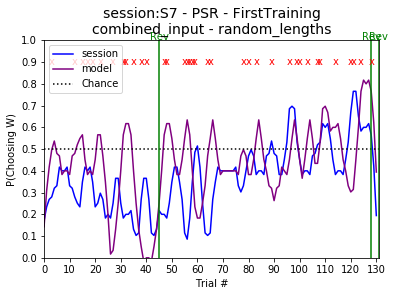

*****KS PASSED - p: 0.95******
***Kuiper PASSED - p: 0.34****


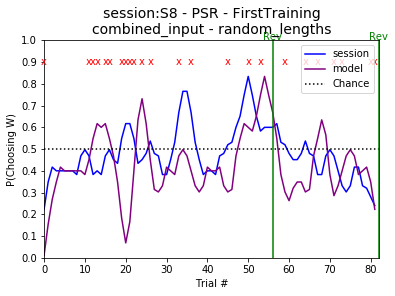

*****KS PASSED - p: 0.36******
***Kuiper FAILED - p: 0.00****


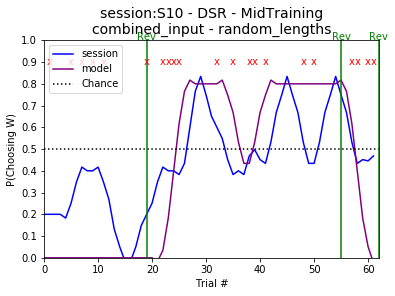

*****KS PASSED - p: 0.96******
***Kuiper PASSED - p: 1.00****


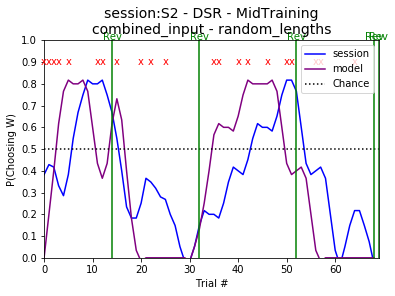

*****KS PASSED - p: 0.57******
***Kuiper PASSED - p: 0.64****


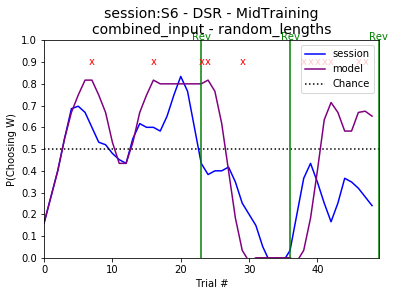

*****KS PASSED - p: 0.07******
***Kuiper FAILED - p: 0.03****


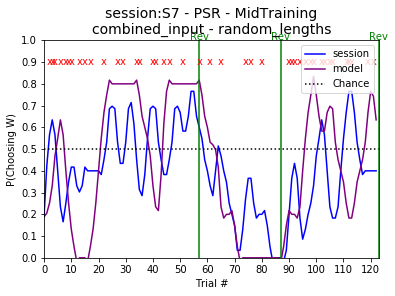

*****KS PASSED - p: 0.64******
***Kuiper FAILED - p: 0.03****


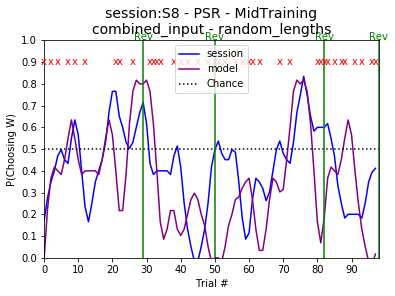

*****KS PASSED - p: 0.84******
***Kuiper PASSED - p: 0.79****


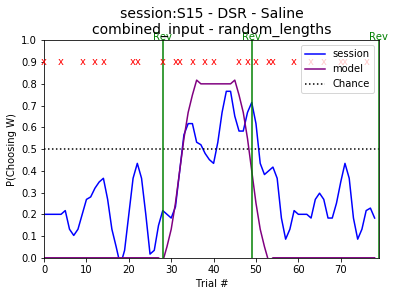

*****KS PASSED - p: 1.00******
***Kuiper PASSED - p: 0.77****


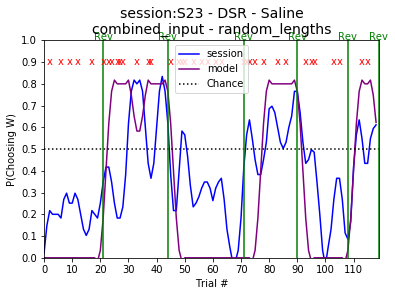

*****KS PASSED - p: 0.84******
***Kuiper PASSED - p: 0.76****


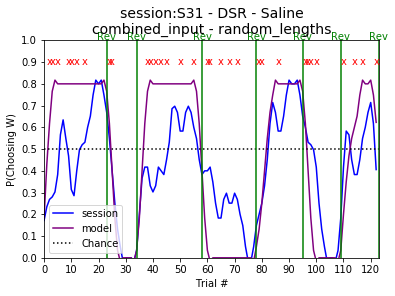

*****KS PASSED - p: 0.93******
***Kuiper PASSED - p: 1.00****


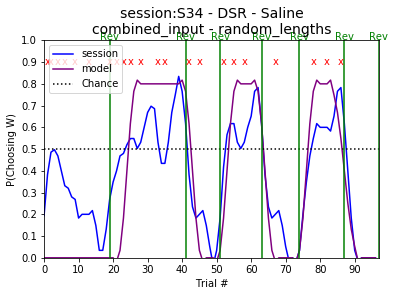

*****KS PASSED - p: 0.17******
***Kuiper PASSED - p: 0.98****


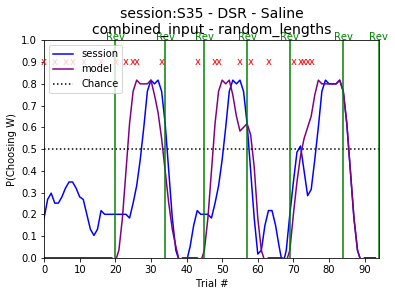

*****KS PASSED - p: 0.29******
***Kuiper PASSED - p: 1.00****


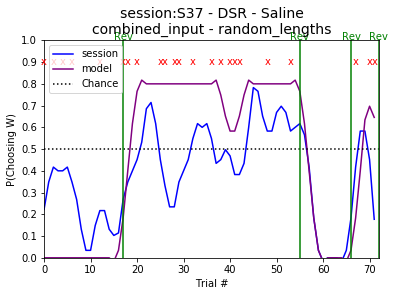

*****KS PASSED - p: 0.28******
***Kuiper PASSED - p: 0.68****


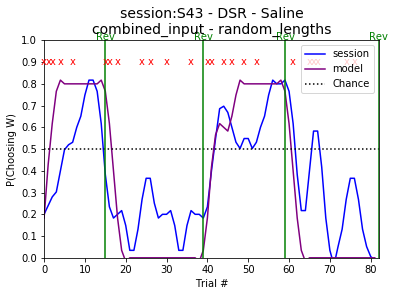

*****KS PASSED - p: 0.86******
***Kuiper PASSED - p: 0.35****


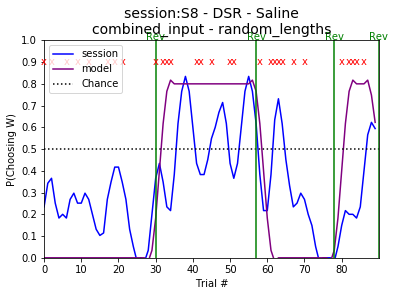

*****KS PASSED - p: 1.00******
***Kuiper PASSED - p: 1.00****


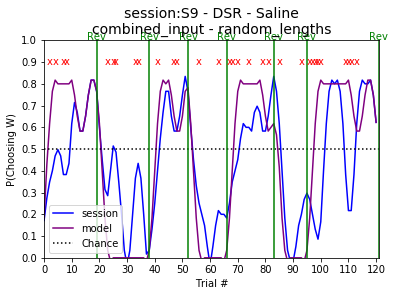

*****KS PASSED - p: 0.90******
***Kuiper PASSED - p: 0.69****


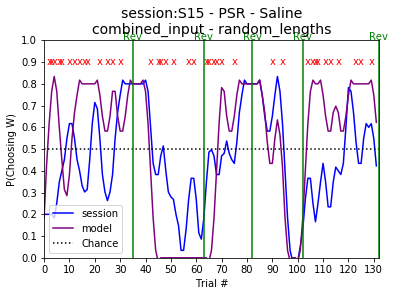

*****KS PASSED - p: 0.43******
***Kuiper PASSED - p: 0.99****


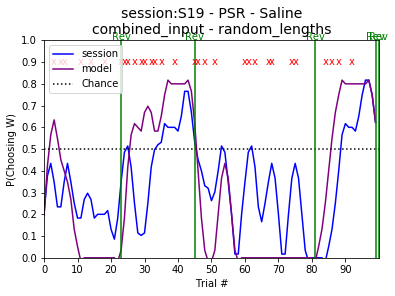

*****KS PASSED - p: 0.59******
***Kuiper PASSED - p: 0.64****


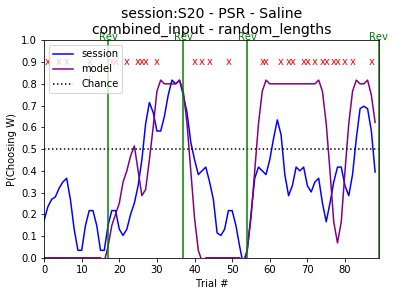

*****KS PASSED - p: 0.46******
***Kuiper PASSED - p: 0.68****


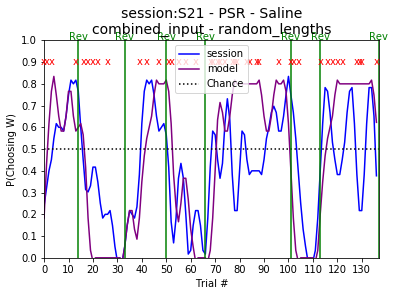

*****KS PASSED - p: 0.87******
***Kuiper PASSED - p: 0.92****


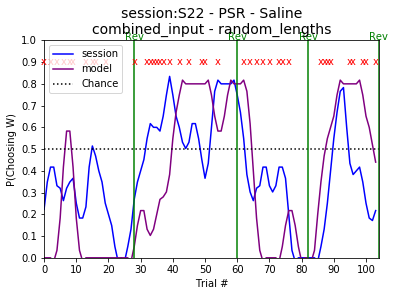

*****KS PASSED - p: 0.98******
***Kuiper PASSED - p: 0.35****


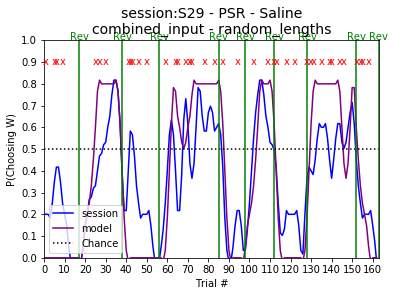

*****KS PASSED - p: 0.87******
***Kuiper PASSED - p: 1.00****


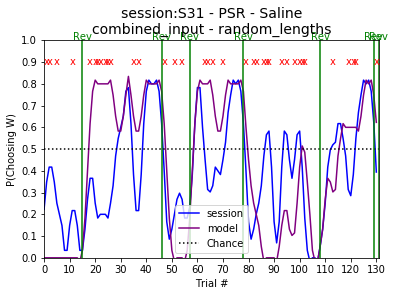

*****KS PASSED - p: 0.86******
***Kuiper PASSED - p: 0.37****


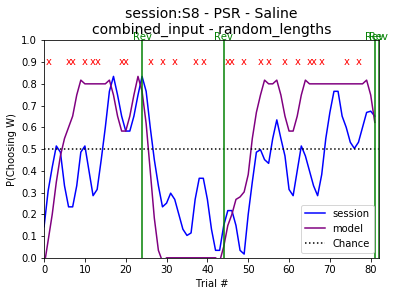

*****KS PASSED - p: 0.99******
***Kuiper PASSED - p: 1.00****


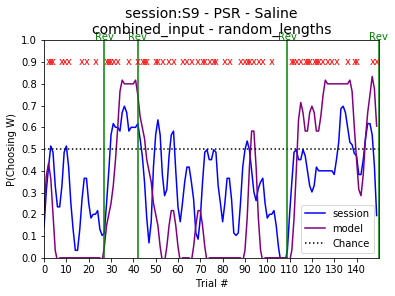

*****KS PASSED - p: 1.00******
***Kuiper FAILED - p: 0.01****


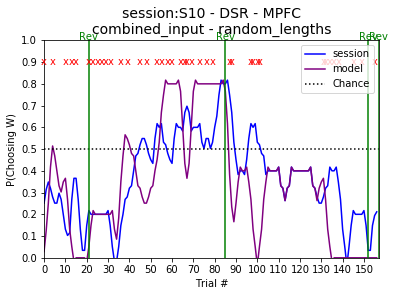

*****KS PASSED - p: 0.25******
***Kuiper FAILED - p: 0.00****


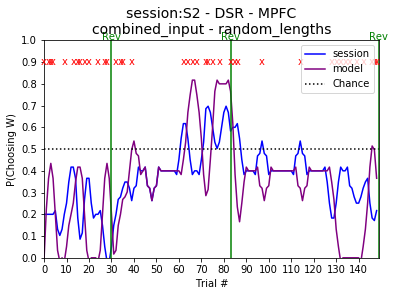

*****KS PASSED - p: 0.20******
***Kuiper PASSED - p: 0.33****


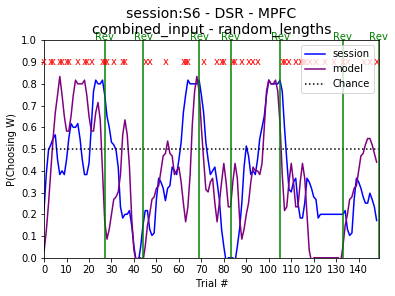

*****KS PASSED - p: 0.63******
***Kuiper PASSED - p: 0.99****


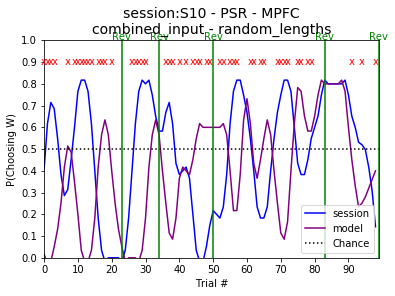

*****KS PASSED - p: 0.24******
***Kuiper PASSED - p: 1.00****


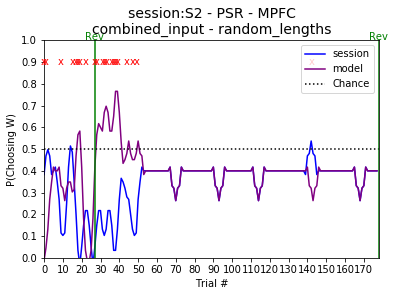

*****KS FAILED - p: 0.00******
***Kuiper PASSED - p: 0.34****


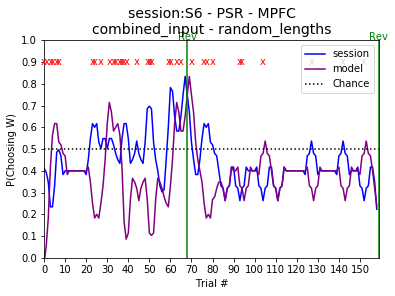

*****KS FAILED - p: 0.00******
***Kuiper FAILED - p: 0.00****


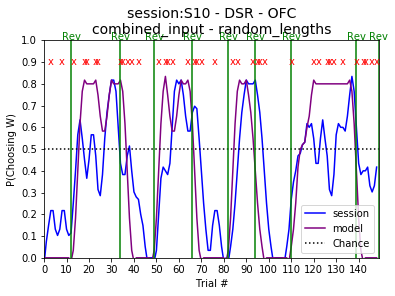

*****KS PASSED - p: 0.93******
***Kuiper PASSED - p: 0.95****


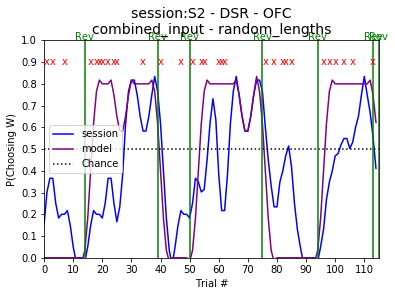

*****KS PASSED - p: 0.81******
***Kuiper PASSED - p: 0.41****


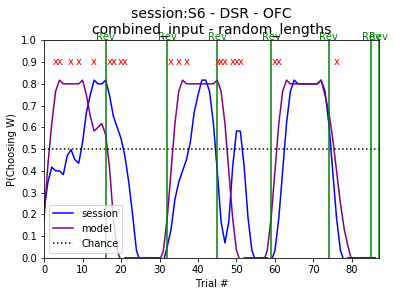

*****KS PASSED - p: 0.07******
***Kuiper PASSED - p: 0.75****


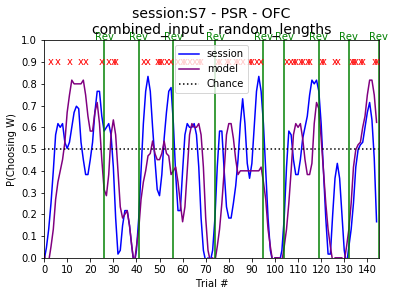

*****KS PASSED - p: 0.30******
***Kuiper PASSED - p: 1.00****


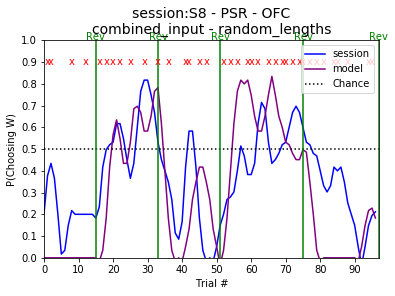

*****KS PASSED - p: 0.82******
***Kuiper PASSED - p: 0.98****


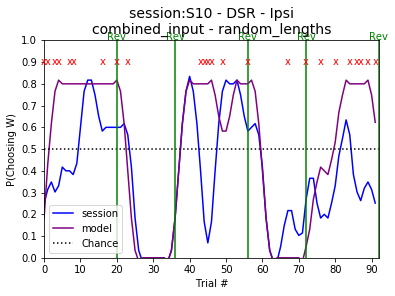

*****KS PASSED - p: 0.50******
***Kuiper PASSED - p: 0.99****


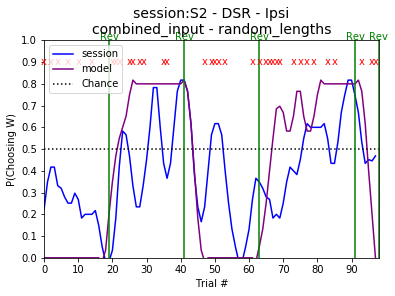

*****KS PASSED - p: 1.00******
***Kuiper PASSED - p: 0.83****


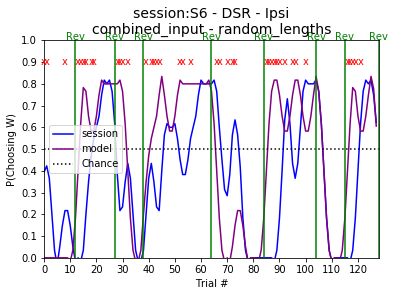

*****KS PASSED - p: 0.78******
***Kuiper PASSED - p: 1.00****


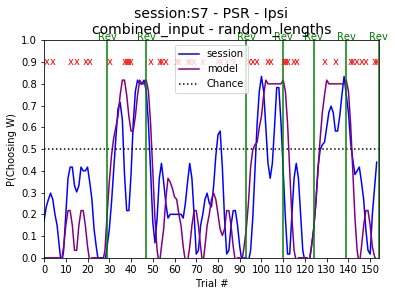

*****KS PASSED - p: 0.93******
***Kuiper PASSED - p: 1.00****


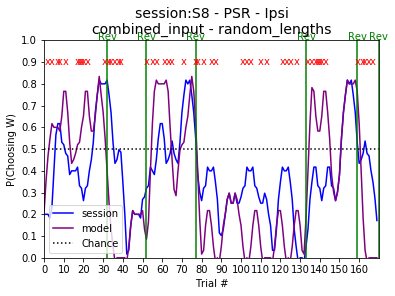

*****KS PASSED - p: 0.75******
***Kuiper PASSED - p: 1.00****


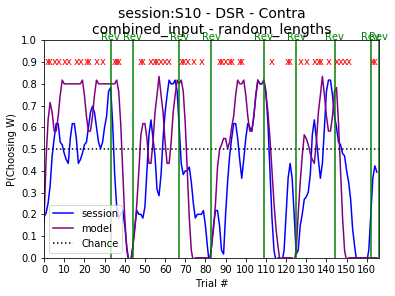

*****KS PASSED - p: 0.56******
***Kuiper PASSED - p: 0.92****


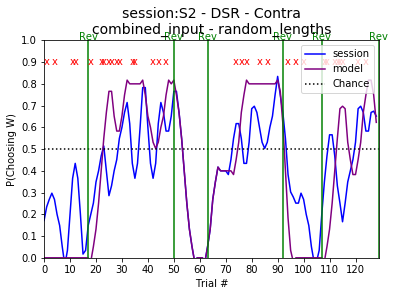

*****KS PASSED - p: 0.56******
***Kuiper PASSED - p: 0.07****


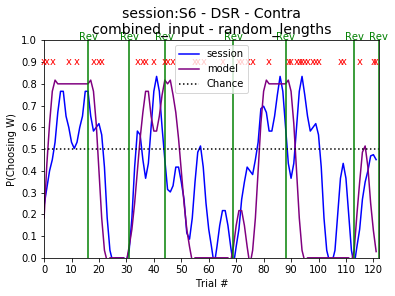

*****KS PASSED - p: 0.67******
***Kuiper PASSED - p: 0.97****


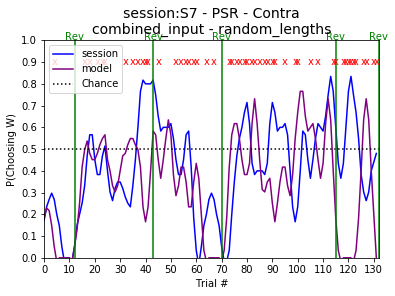

*****KS PASSED - p: 0.24******
***Kuiper PASSED - p: 0.69****


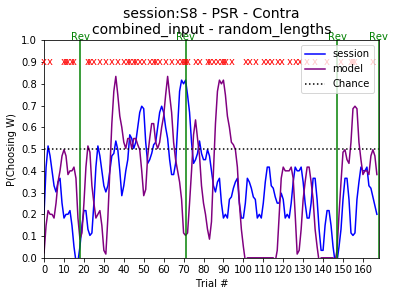

*****KS PASSED - p: 0.23******
***Kuiper PASSED - p: 0.43****


In [11]:
HDO = pickle.load(open(ROOT + 'Model_Evaluation/RNN/hidden_dimension_optimization.p', 'rb'))

dt = 'combined_input'
ss = 'random_lengths'

if dt == 'combined_input':
    test_func = test_model_on_test_set_combined
elif dt == 'not_combined':
    test_func = test_model_on_test_not_combined
failedSessions = dict()
for fileName in fileNames:
    failedSessions[fileName] = [0,0,0]
    model_task, model_regime = filename_to_label(fileName)
    
    #loading the highest scoring model
    hd = int(HDO.loc[fileName, idx[dt,ss]])
    model_path = '/'.join([model_dir, dt, ss, fileName[:fileName.find('.')] + str(hd) + '.p'])
    model = pickle.load(open(model_path, 'rb'))

    #load appropriate sequences 
    sequence_path = '/'.join([sequence_dir, dt, ss, fileName])
    seqObject = pickle.load(open(sequence_path, 'rb'))

    #test model on leftover sessions
    model_preds = []
    for x_seq, y_seq in zip(seqObject.X_test, seqObject.y_test):
        hits, totalTrials, predictions = test_func(model, x_seq.values, y_seq.values )
        model_preds.append(pd.Series(predictions, index=x_seq.index))


    model_preds = pd.concat(model_preds, axis=0)
    test_sessions = pd.concat(seqObject.X_test, axis=0)
    if dt == 'combined_input':
        test_sessions = test_sessions['W']
        test_sessions = pd.DataFrame(test_sessions.values,
                                     index = test_sessions.index,
                                     columns = pd.MultiIndex.from_product([['choice'],[0]]))
    elif dt == 'not_combined':
        tmp_vals = test_sessions.values
        tmp_vals = np.nonzero(tmp_vals)[1]
        tmp_vals[tmp_vals < 2] = 0
        tmp_vals[tmp_vals > 1] = 1
        test_sessions = pd.DataFrame(tmp_vals,
                                     index = test_sessions.index,
                                     columns=pd.MultiIndex.from_product([['choice'],[0]]))



    for (test_label, test_session), (model_label, model_session) \
        in zip(test_sessions.groupby(axis=0, level = 'session'),
               model_preds.groupby(axis=0, level = 'session')):
        
        #plot model against real session
        title = 'session:%s - %s - %s\n%s - %s' %(test_label, model_task, model_regime, dt, ss)
        plot_session_model_errors(test_session, model_session, window_size = 5, title = title)
        
        #Kolmogorov - Smirnov test
        errorDecoding = np.nonzero(model_session != test_session['choice', 0])[0]
        p = ks_test_model(errorDecoding, len(test_session))
        if p < 0.05: 
            print '{:*^30}'.format('KS FAILED - p: %1.2f' %p)
            failedSessions[fileName][0] += 1
        else: 
            print '{:*^30}'.format('KS PASSED - p: %1.2f' %p)
            
        #Kuiper's test
        blocks = test_session.groupby(axis=0, level = 'block')
        blockLengths = [len(l) for b,l in blocks]
        blockIndex = [0] + list(np.cumsum(blockLengths))
        angles = []
        for bindex in range(len(blockIndex) - 1):
            tmp_block_length = blockLengths[bindex]
            tmp_slice = errorDecoding[blockIndex[bindex] : blockIndex[bindex + 1]]
            angles += list((np.nonzero(tmp_slice)[0] / np.float(tmp_block_length)))
        D, p_kuiper = kuiper(angles, uniform.cdf)
        if p_kuiper < 0.05: 
            print '{:*^30}'.format('Kuiper FAILED - p: %1.2f' %p_kuiper)
            failedSessions[fileName][1] += 1
        else: 
            print '{:*^30}'.format('Kuiper PASSED - p: %1.2f' %p_kuiper)
        failedSessions[fileName][2] += 1 

        

In [12]:
for regime in failedSessions.keys():
    print regime
    print 'failed KS: %i - failed Kuiper: %i - total sessions: %i' %tuple(failedSessions[regime])

PSR_TbyT_Ipsi.p
failed KS: 0 - failed Kuiper: 0 - total sessions: 2
PSR_TbyT_Contra.p
failed KS: 0 - failed Kuiper: 0 - total sessions: 2
DSR_TbyT_Contra.p
failed KS: 0 - failed Kuiper: 0 - total sessions: 3
DSR_TbyT_Ipsi.p
failed KS: 0 - failed Kuiper: 0 - total sessions: 3
PSR_TbyT_MPFC.p
failed KS: 2 - failed Kuiper: 1 - total sessions: 3
PSR_TbyT_Saline.p
failed KS: 0 - failed Kuiper: 1 - total sessions: 9
PSR_TbyT_OFC.p
failed KS: 0 - failed Kuiper: 0 - total sessions: 2
PSR_TbyT_FirstTraining.p
failed KS: 0 - failed Kuiper: 1 - total sessions: 2
DSR_TbyT_MidTraining.p
failed KS: 0 - failed Kuiper: 1 - total sessions: 3
DSR_TbyT_FirstTraining.p
failed KS: 0 - failed Kuiper: 0 - total sessions: 3
PSR_TbyT_MidTraining.p
failed KS: 0 - failed Kuiper: 1 - total sessions: 2
DSR_TbyT_OFC.p
failed KS: 0 - failed Kuiper: 0 - total sessions: 3
DSR_TbyT_MPFC.p
failed KS: 0 - failed Kuiper: 1 - total sessions: 3
DSR_TbyT_Saline.p
failed KS: 0 - failed Kuiper: 0 - total sessions: 9


## Addendum

Thru a bit of a bug we might have found that overlapping sequences may help train the network. This helps us get more 'juice' out of the data. Essentially, if we have a session that is 100 trials long, we don't break it into 10 sequences of 10 trials, but rather we break it up into 20 sequences of 8 trials, for example. Trials will be repeated accross sessions, but they will be the tail, or the head of the sequence depending on the split. We will also try much shorter sequences because we are dealing with 'vanilla' RNNs. We will be creating 3 new types of splitting the data, for both combined and not combined inputs:

1) non-overlapping short sequences
2) overlapping short sequences
3) overlapping long sequences
4) "random lengths" of analysis above would be -> non-overlapping long sequences

This is a LOT of data, and it will be the last variant with 'vanilla' RNNs that we try. We will train networks with smaller architectures on epsilon overnight with these new splits. 

In [3]:

sequence_split = ['overlapping','non_overlapping']
sequence_length = ['long','short']

for fileName, dt, ss, sl in itertools.product(fileNames, data_type, sequence_split, sequence_length):
    print 'processing dataset %s - %s - %s - %s' %(fileName, dt, ss, sl)
    
    #loading data
    df = pickle.load(open(data_dir + fileName, 'rb'))

    
    #split into train and test split
    train_slice, test_slice = my_train_test_split(df, RANDOM_STATE = RANDOM_STATE)
    
    #transform data to right format
    if dt == 'combined_input':
        data = choice_reward_combined(df)
        split_xy = sequence_to_xy_combined
    elif dt == 'not_combined':
        data = choice_reward_not_combined(df)
        split_xy = sequence_to_xy_not_combined


    #actually split data into train and test sets
    if len(data.shape) == 1:
        train = data.loc[train_slice]
        test = data.loc[test_slice]             
    elif len(data.shape) == 2:
        train = data.loc[train_slice, :]
        test = data.loc[test_slice, :] 

    #create object
    sequence_set = Sequences(dt, ss + '_' + sl, RANDOM_STATE = RANDOM_STATE)


    train_sequences = []
    test_sequences = []
    for label, session in train.groupby(axis = 0, level = 'session'):
        if sl == 'short':
            train_sequences += \
                random_split_session(session, mu = 12, sigma = 4, overlap = int(ss == 'overlapping'))
        elif sl == 'long':
            train_sequences += \
                random_split_session(session, mu = 20, sigma = 7, overlap = int(ss == 'overlapping'))   
                
    for label, session in test.groupby(axis = 0, level = 'session'):
        if sl == 'short':
            test_sequences += \
                random_split_session(session, mu = 12, sigma = 4, overlap = int(ss == 'overlapping'))
        elif sl == 'long':
            test_sequences += \
                random_split_session(session, mu = 20, sigma = 7, overlap = int(ss == 'overlapping'))   
                
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    for setIndex, Set in enumerate([train_sequences, test_sequences]):
        for seq in Set:
            X, y = split_xy(seq)
            if setIndex == 0:
                X_train.append(X)
                y_train.append(y)
            else: 
                X_test.append(X)
                y_test.append(y)

    sequence_set.X_train = X_train
    sequence_set.y_train = y_train
    sequence_set.X_test = X_test
    sequence_set.y_test = y_test
    path = '/'.join([sequence_dir, dt, 'random_lengths', ss, sl, fileName])
    pickle.dump(sequence_set, open(path, 'wb'))
    print 'created sequence object %s - %s - %s' %(dt, ss, sl)
            
print 'DONE.'

processing dataset DSR_TbyT_FirstTraining.p - combined_input - overlapping - long
created sequence object combined_input - overlapping - long
processing dataset DSR_TbyT_FirstTraining.p - combined_input - overlapping - short
created sequence object combined_input - overlapping - short
processing dataset DSR_TbyT_FirstTraining.p - combined_input - non_overlapping - long
created sequence object combined_input - non_overlapping - long
processing dataset DSR_TbyT_FirstTraining.p - combined_input - non_overlapping - short
created sequence object combined_input - non_overlapping - short
processing dataset DSR_TbyT_FirstTraining.p - not_combined - overlapping - long
created sequence object not_combined - overlapping - long
processing dataset DSR_TbyT_FirstTraining.p - not_combined - overlapping - short
created sequence object not_combined - overlapping - short
processing dataset DSR_TbyT_FirstTraining.p - not_combined - non_overlapping - long
created sequence object not_combined - non_overlap

created sequence object combined_input - non_overlapping - long
processing dataset PSR_TbyT_MPFC.p - combined_input - non_overlapping - short
created sequence object combined_input - non_overlapping - short
processing dataset PSR_TbyT_MPFC.p - not_combined - overlapping - long
created sequence object not_combined - overlapping - long
processing dataset PSR_TbyT_MPFC.p - not_combined - overlapping - short
created sequence object not_combined - overlapping - short
processing dataset PSR_TbyT_MPFC.p - not_combined - non_overlapping - long
created sequence object not_combined - non_overlapping - long
processing dataset PSR_TbyT_MPFC.p - not_combined - non_overlapping - short
created sequence object not_combined - non_overlapping - short
processing dataset DSR_TbyT_OFC.p - combined_input - overlapping - long
created sequence object combined_input - overlapping - long
processing dataset DSR_TbyT_OFC.p - combined_input - overlapping - short
created sequence object combined_input - overlapping

In [4]:
cols = pd.MultiIndex.from_product([data_type,sequence_split, sequence_length],
                                  names = ['data_type', 'seq_split', 'seq_length'])
hidden_dimension_optimized = pd.DataFrame(np.zeros([len(fileNames), len(cols)], dtype=int),
                                          index = fileNames,
                                          columns = cols)

for dt, ss, sl, fileName in itertools.product(data_type, sequence_split, sequence_length, fileNames):
    if dt == 'combined_input':
        test_func = test_model_on_test_set_combined
    elif dt == 'not_combined':
        test_func = test_model_on_test_not_combined
        
    #load appropriate sequences 
    sequence_path = '/'.join([sequence_dir, dt, 'random_lengths', ss, sl, fileName])
    seqObject = pickle.load(open(sequence_path, 'rb'))
    
    #getting all models that were trained for that dataset
    model_path = '/'.join([model_dir, dt, 'random_lengths', ss, sl])
    trained_models = [trained_model for trained_model in os.listdir(model_path) \
                      if trained_model.startswith(fileName[:-2])]
    model_scores = dict()
    #we iterate thru all trained models
    for hd_index, trained_model in enumerate(trained_models):
        #load model
        model_path = '/'.join([model_dir, dt, 'random_lengths', ss, sl, trained_model])
        model = pickle.load(open(model_path, 'rb'))
        
        #check that data was split the same way 
        if seqObject.RANDOM_STATE != model.random_state:
            print 'ERROR - %s - %s' %(sequence_path, model_path)
            
        #go thru each sequence and test prediction accuracy    
        hits, noTrials = 0, 0
        for x, y in zip(seqObject.X_test, seqObject.y_test):
            h, nT, preds = test_func(model, x.values, y.values)
            hits += h
            noTrials += nT
        model_scores[trained_model] = np.float(hits) / noTrials
        
    winner = max(model_scores, key=model_scores.get)
    HD_optimal = int(winner[len(fileName[:-2]):-2])

    hidden_dimension_optimized.loc[fileName, idx[dt, ss, sl]] = HD_optimal
    print 'for %s - %s - %s - %s .... optimal dimension is %i - score: %1.4f' \
    %(fileName, dt, ss, sl, HD_optimal,  np.max(model_scores.values()))

pickle.dump(hidden_dimension_optimized,
            open(ROOT + 'Model_Evaluation/RNN/hidden_dimension_optimization2.p', 'wb'))
print 'DONE.'

for DSR_TbyT_FirstTraining.p - combined_input - overlapping - long .... optimal dimension is 5 - score: 0.6838
for PSR_TbyT_FirstTraining.p - combined_input - overlapping - long .... optimal dimension is 8 - score: 0.7259
for DSR_TbyT_MidTraining.p - combined_input - overlapping - long .... optimal dimension is 5 - score: 0.7444
for PSR_TbyT_MidTraining.p - combined_input - overlapping - long .... optimal dimension is 10 - score: 0.6385
for DSR_TbyT_Saline.p - combined_input - overlapping - long .... optimal dimension is 4 - score: 0.7320
for PSR_TbyT_Saline.p - combined_input - overlapping - long .... optimal dimension is 8 - score: 0.6863
for DSR_TbyT_MPFC.p - combined_input - overlapping - long .... optimal dimension is 10 - score: 0.7070
for PSR_TbyT_MPFC.p - combined_input - overlapping - long .... optimal dimension is 4 - score: 0.7714
for DSR_TbyT_OFC.p - combined_input - overlapping - long .... optimal dimension is 5 - score: 0.7356
for PSR_TbyT_OFC.p - combined_input - overlap

for PSR_TbyT_MPFC.p - not_combined - overlapping - short .... optimal dimension is 4 - score: 0.7557
for DSR_TbyT_OFC.p - not_combined - overlapping - short .... optimal dimension is 50 - score: 0.6884
for PSR_TbyT_OFC.p - not_combined - overlapping - short .... optimal dimension is 5 - score: 0.5731
for DSR_TbyT_Ipsi.p - not_combined - overlapping - short .... optimal dimension is 2 - score: 0.6832
for PSR_TbyT_Ipsi.p - not_combined - overlapping - short .... optimal dimension is 5 - score: 0.7143
for DSR_TbyT_Contra.p - not_combined - overlapping - short .... optimal dimension is 4 - score: 0.6948
for PSR_TbyT_Contra.p - not_combined - overlapping - short .... optimal dimension is 200 - score: 0.5663
for DSR_TbyT_FirstTraining.p - not_combined - non_overlapping - long .... optimal dimension is 2 - score: 0.8439
for PSR_TbyT_FirstTraining.p - not_combined - non_overlapping - long .... optimal dimension is 12 - score: 0.6550
for DSR_TbyT_MidTraining.p - not_combined - non_overlapping -

working on combined_input - overlapping - long - DSR - FirstTraining
/Users/pablomartin/python/Models/RNN/combined_input/random_lengths/overlapping/long/DSR_TbyT_FirstTraining5.p
working on combined_input - overlapping - long - PSR - FirstTraining
/Users/pablomartin/python/Models/RNN/combined_input/random_lengths/overlapping/long/PSR_TbyT_FirstTraining8.p
working on combined_input - overlapping - long - DSR - MidTraining
/Users/pablomartin/python/Models/RNN/combined_input/random_lengths/overlapping/long/DSR_TbyT_MidTraining5.p
working on combined_input - overlapping - long - PSR - MidTraining
/Users/pablomartin/python/Models/RNN/combined_input/random_lengths/overlapping/long/PSR_TbyT_MidTraining10.p
working on combined_input - overlapping - long - DSR - Saline
/Users/pablomartin/python/Models/RNN/combined_input/random_lengths/overlapping/long/DSR_TbyT_Saline4.p
working on combined_input - overlapping - long - PSR - Saline
/Users/pablomartin/python/Models/RNN/combined_input/random_lengt

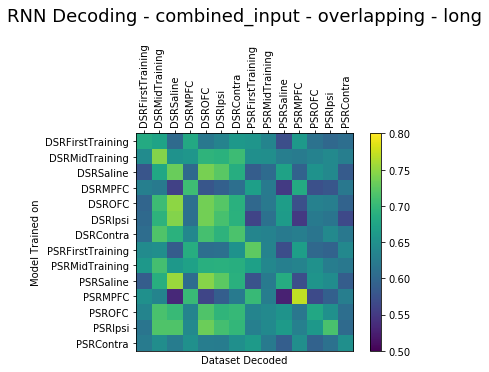

***done with sequence type****
working on combined_input - overlapping - short - DSR - FirstTraining
/Users/pablomartin/python/Models/RNN/combined_input/random_lengths/overlapping/short/DSR_TbyT_FirstTraining200.p
working on combined_input - overlapping - short - PSR - FirstTraining
/Users/pablomartin/python/Models/RNN/combined_input/random_lengths/overlapping/short/PSR_TbyT_FirstTraining4.p
working on combined_input - overlapping - short - DSR - MidTraining
/Users/pablomartin/python/Models/RNN/combined_input/random_lengths/overlapping/short/DSR_TbyT_MidTraining5.p
working on combined_input - overlapping - short - PSR - MidTraining
/Users/pablomartin/python/Models/RNN/combined_input/random_lengths/overlapping/short/PSR_TbyT_MidTraining8.p
working on combined_input - overlapping - short - DSR - Saline
/Users/pablomartin/python/Models/RNN/combined_input/random_lengths/overlapping/short/DSR_TbyT_Saline5.p
working on combined_input - overlapping - short - PSR - Saline
/Users/pablomartin/py

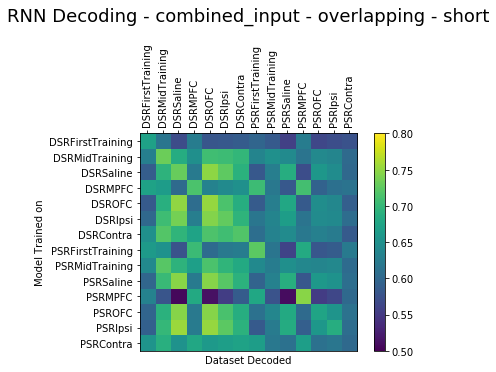

***done with sequence type****
working on combined_input - non_overlapping - long - DSR - FirstTraining
/Users/pablomartin/python/Models/RNN/combined_input/random_lengths/non_overlapping/long/DSR_TbyT_FirstTraining7.p
working on combined_input - non_overlapping - long - PSR - FirstTraining
/Users/pablomartin/python/Models/RNN/combined_input/random_lengths/non_overlapping/long/PSR_TbyT_FirstTraining6.p
working on combined_input - non_overlapping - long - DSR - MidTraining
/Users/pablomartin/python/Models/RNN/combined_input/random_lengths/non_overlapping/long/DSR_TbyT_MidTraining3.p
working on combined_input - non_overlapping - long - PSR - MidTraining
/Users/pablomartin/python/Models/RNN/combined_input/random_lengths/non_overlapping/long/PSR_TbyT_MidTraining10.p
working on combined_input - non_overlapping - long - DSR - Saline
/Users/pablomartin/python/Models/RNN/combined_input/random_lengths/non_overlapping/long/DSR_TbyT_Saline3.p
working on combined_input - non_overlapping - long - PS

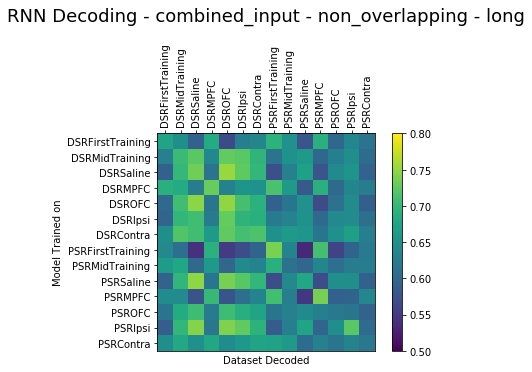

***done with sequence type****
working on combined_input - non_overlapping - short - DSR - FirstTraining
/Users/pablomartin/python/Models/RNN/combined_input/random_lengths/non_overlapping/short/DSR_TbyT_FirstTraining15.p
working on combined_input - non_overlapping - short - PSR - FirstTraining
/Users/pablomartin/python/Models/RNN/combined_input/random_lengths/non_overlapping/short/PSR_TbyT_FirstTraining4.p
working on combined_input - non_overlapping - short - DSR - MidTraining
/Users/pablomartin/python/Models/RNN/combined_input/random_lengths/non_overlapping/short/DSR_TbyT_MidTraining4.p
working on combined_input - non_overlapping - short - PSR - MidTraining
/Users/pablomartin/python/Models/RNN/combined_input/random_lengths/non_overlapping/short/PSR_TbyT_MidTraining10.p
working on combined_input - non_overlapping - short - DSR - Saline
/Users/pablomartin/python/Models/RNN/combined_input/random_lengths/non_overlapping/short/DSR_TbyT_Saline4.p
working on combined_input - non_overlapping 

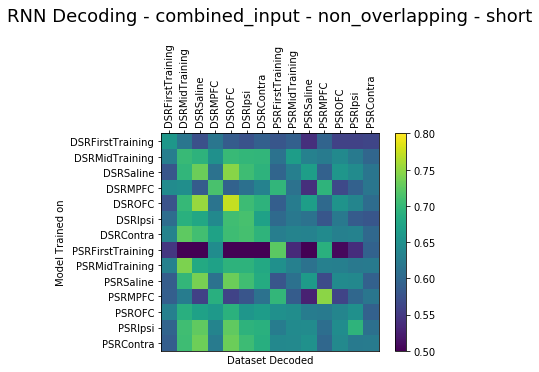

***done with sequence type****
working on not_combined - overlapping - long - DSR - FirstTraining
/Users/pablomartin/python/Models/RNN/not_combined/random_lengths/overlapping/long/DSR_TbyT_FirstTraining2.p
working on not_combined - overlapping - long - PSR - FirstTraining
/Users/pablomartin/python/Models/RNN/not_combined/random_lengths/overlapping/long/PSR_TbyT_FirstTraining5.p
working on not_combined - overlapping - long - DSR - MidTraining
/Users/pablomartin/python/Models/RNN/not_combined/random_lengths/overlapping/long/DSR_TbyT_MidTraining5.p
working on not_combined - overlapping - long - PSR - MidTraining
/Users/pablomartin/python/Models/RNN/not_combined/random_lengths/overlapping/long/PSR_TbyT_MidTraining15.p
working on not_combined - overlapping - long - DSR - Saline
/Users/pablomartin/python/Models/RNN/not_combined/random_lengths/overlapping/long/DSR_TbyT_Saline8.p
working on not_combined - overlapping - long - PSR - Saline
/Users/pablomartin/python/Models/RNN/not_combined/rando

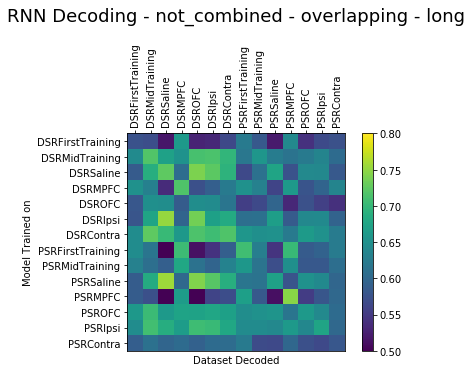

***done with sequence type****
working on not_combined - overlapping - short - DSR - FirstTraining
/Users/pablomartin/python/Models/RNN/not_combined/random_lengths/overlapping/short/DSR_TbyT_FirstTraining20.p
working on not_combined - overlapping - short - PSR - FirstTraining
/Users/pablomartin/python/Models/RNN/not_combined/random_lengths/overlapping/short/PSR_TbyT_FirstTraining5.p
working on not_combined - overlapping - short - DSR - MidTraining
/Users/pablomartin/python/Models/RNN/not_combined/random_lengths/overlapping/short/DSR_TbyT_MidTraining5.p
working on not_combined - overlapping - short - PSR - MidTraining
/Users/pablomartin/python/Models/RNN/not_combined/random_lengths/overlapping/short/PSR_TbyT_MidTraining15.p
working on not_combined - overlapping - short - DSR - Saline
/Users/pablomartin/python/Models/RNN/not_combined/random_lengths/overlapping/short/DSR_TbyT_Saline8.p
working on not_combined - overlapping - short - PSR - Saline
/Users/pablomartin/python/Models/RNN/not_co

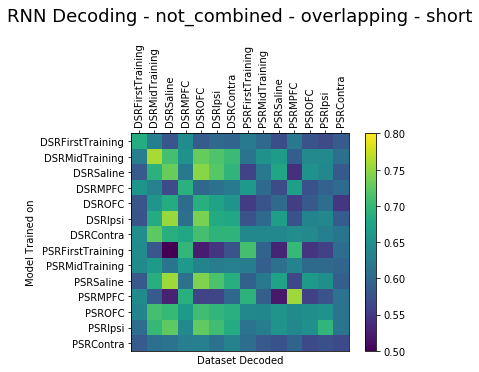

***done with sequence type****
working on not_combined - non_overlapping - long - DSR - FirstTraining
/Users/pablomartin/python/Models/RNN/not_combined/random_lengths/non_overlapping/long/DSR_TbyT_FirstTraining2.p
working on not_combined - non_overlapping - long - PSR - FirstTraining
/Users/pablomartin/python/Models/RNN/not_combined/random_lengths/non_overlapping/long/PSR_TbyT_FirstTraining12.p
working on not_combined - non_overlapping - long - DSR - MidTraining
/Users/pablomartin/python/Models/RNN/not_combined/random_lengths/non_overlapping/long/DSR_TbyT_MidTraining5.p
working on not_combined - non_overlapping - long - PSR - MidTraining
/Users/pablomartin/python/Models/RNN/not_combined/random_lengths/non_overlapping/long/PSR_TbyT_MidTraining15.p
working on not_combined - non_overlapping - long - DSR - Saline
/Users/pablomartin/python/Models/RNN/not_combined/random_lengths/non_overlapping/long/DSR_TbyT_Saline6.p
working on not_combined - non_overlapping - long - PSR - Saline
/Users/pab

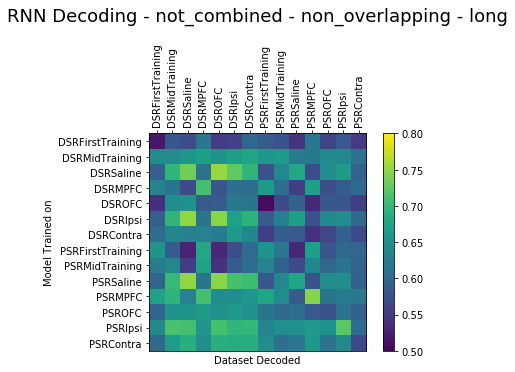

***done with sequence type****
working on not_combined - non_overlapping - short - DSR - FirstTraining
/Users/pablomartin/python/Models/RNN/not_combined/random_lengths/non_overlapping/short/DSR_TbyT_FirstTraining2.p
working on not_combined - non_overlapping - short - PSR - FirstTraining
/Users/pablomartin/python/Models/RNN/not_combined/random_lengths/non_overlapping/short/PSR_TbyT_FirstTraining5.p
working on not_combined - non_overlapping - short - DSR - MidTraining
/Users/pablomartin/python/Models/RNN/not_combined/random_lengths/non_overlapping/short/DSR_TbyT_MidTraining5.p
working on not_combined - non_overlapping - short - PSR - MidTraining
/Users/pablomartin/python/Models/RNN/not_combined/random_lengths/non_overlapping/short/PSR_TbyT_MidTraining15.p
working on not_combined - non_overlapping - short - DSR - Saline
/Users/pablomartin/python/Models/RNN/not_combined/random_lengths/non_overlapping/short/DSR_TbyT_Saline8.p
working on not_combined - non_overlapping - short - PSR - Saline


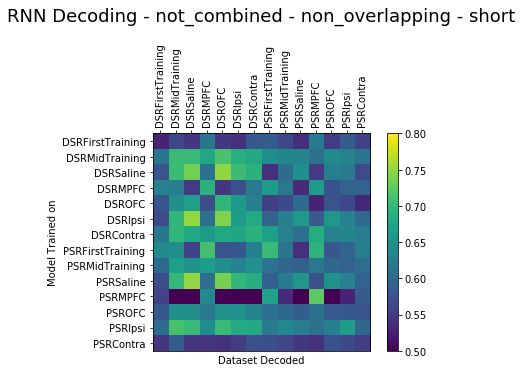

***done with sequence type****


In [5]:
HDO = pickle.load(open(ROOT + 'Model_Evaluation/RNN/hidden_dimension_optimization2.p', 'rb'))
for dt, ss, sl in itertools.product(data_type, sequence_split, sequence_length):
    if dt == 'combined_input':
        test_func = test_model_on_test_set_combined
    elif dt == 'not_combined':
        test_func = test_model_on_test_not_combined
    scores = create_model_grid()
    for fileName in fileNames:
        model_task, model_regime = filename_to_label(fileName)
        print 'working on %s - %s - %s - %s - %s' %(dt, ss, sl, model_task, model_regime)
        #loading the highest scoring model
        hd = HDO.loc[fileName, idx[dt,ss,sl]]
        model_path = '/'.join([model_dir, dt, 'random_lengths', ss, sl,
                               fileName[:fileName.find('.')] + str(hd) + '.p'])
        print model_path
        model = pickle.load(open(model_path, 'rb'))
        #now we iterate thru the datasets
        for compFileName in fileNames:
            data_task, data_regime = filename_to_label(compFileName)
            #load appropriate sequences 
            sequence_path = '/'.join([sequence_dir, dt, 'random_lengths', ss, sl, compFileName])
            seqObject = pickle.load(open(sequence_path, 'rb'))
            #run model on test set
            if fileName == compFileName:
                X = seqObject.X_test
                y = seqObject.y_test
            #if not same dataset, we can use entire data to test model
            else:
                X = seqObject.X_test + seqObject.X_train
                y = seqObject.y_test + seqObject.y_train
            hits = 0
            totalTrials = 0
            for X_seq, y_seq in zip(X, y):
                h, nT, preds = test_func(model, X_seq.values, y_seq.values)
                hits += h
                totalTrials += nT      
            scores.loc[idx[model_task, model_regime], 
                       idx[data_task, data_regime ]] = np.float(hits) / totalTrials
            
    pickle.dump(scores,
                open(ROOT + 'Model_Evaluation/RNN/model_grid' + '_'.join(['',dt,ss,sl,'.p']), 'wb'))
    plot_model_grid(scores, [0.5, 0.8], title = 'RNN Decoding - %s - %s - %s' %(dt, ss, sl))
    print '{:*^30}'.format('done with sequence type')

## Best Of
Ok, this is getting ridiculous. We have tried 2120 network variations ! We will get the best of accross sequence split, still not sure if this is legit, but let's keep this as the BEST that we have come up with so far. This will set the benchmark to break for LSTMs. 

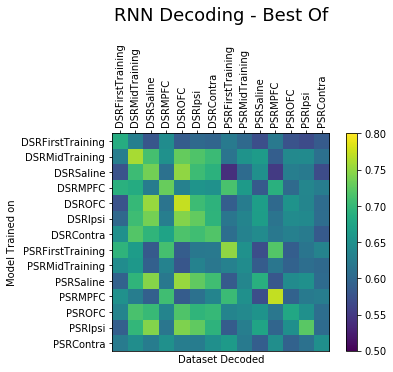

In [3]:
scores = []
BEST_OF = create_model_grid()
for grid in [grid for grid in os.listdir(ROOT + 'Model_Evaluation/RNN/') if grid.startswith('model_grid')]:
    scores.append(pickle.load(open(ROOT + 'Model_Evaluation/RNN/' + grid, 'rb')))
for model in range(14):
    diagonal_scores = [w.iloc[model, model] for w in scores]
    winner = np.argmax(diagonal_scores)
    BEST_OF.iloc[model] = scores[winner].iloc[model]
    
plot_model_grid(BEST_OF, [0.5, 0.8], title = 'RNN Decoding - Best Of')

In [5]:
print BEST_OF.values.diagonal()

[ 0.68613139  0.76027397  0.73642384  0.73023256  0.77377049  0.72773973
  0.71798365  0.75        0.64593301  0.68908382  0.77239709  0.68019093
  0.72312704  0.64962121]
